In [ ]:
%%capture
!pip install fairlearn

In [ ]:
#@markdown Load modules
import numpy as np
from IPython.display import display, Markdown, Latex
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score

from fairlearn.postprocessing import ThresholdOptimizer
from fairlearn.preprocessing import CorrelationRemover
from fairlearn.adversarial import AdversarialFairnessClassifier
from fairlearn.metrics import MetricFrame
import fairlearn.datasets as fdata
from fairlearn.metrics import (demographic_parity_difference, demographic_parity_ratio, 
                               selection_rate_difference, false_negative_rate_difference, 
                               false_positive_rate_difference, equalized_odds_ratio,
                               false_negative_rate, false_positive_rate)

# Load and preprocess the data

In [ ]:
#@markdown Load and read about the dataset.
# get datast from fairlearn and show description
dataset = fdata.fetch_diabetes_hospital()

display(Markdown(dataset.DESCR))

# save dataframe and features
x_raw = dataset.data
# y_raw = np.array(dataset.target)
feature_names = dataset.feature_names

/usr/local/lib/python3.8/dist-packages/sklearn/datasets/_openml.py:932: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


The "Diabetes 130-Hospitals" dataset represents 10 years of clinical care at 130 U.S. hospitals and delivery networks, collected from 1999 to 2008. Each record represents the hospital admission record for a patient diagnosed with diabetes whose stay lasted between one to fourteen days. The features describing each encounter include demographics, diagnoses, diabetic medications, number of visits in the year preceding the encounter, and payer information, as well as whether the patient was readmitted after release, and whether the readmission occurred within 30 days of the release.

The original "Diabetes 130-Hospitals" dataset was collected by Beata Strack, Jonathan P. DeShazo, Chris Gennings, Juan L. Olmo, Sebastian Ventura, Krzysztof J. Cios, and John N. Clore in 2014.

This version of the dataset was derived by the Fairlearn team for the SciPy 2021 tutorial "Fairness in AI Systems: From social context to practice using Fairlearn". In this version, the target variable "readmitted" is binarized into whether the patient was re-admitted within thirty days. The full dataset pre-processing script can be found on GitHub: https://github.com/fairlearn/talks/blob/main/2021_scipy_tutorial/preprocess.py

Downloaded from openml.org.

You can read more about the dataset [here](https://fairlearn.org/main/user_guide/datasets/diabetes_hospital_data.html). In this description, we see that two features, `readmitted` and `readmit_binary`, are other representations of the same outcome, so we drop them from the set of predictors.

In [ ]:
#@markdown Down sample to make runtimes reasonable
x_raw = x_raw.sample(frac=0.1, random_state=123)

In [ ]:
y_raw = x_raw['readmit_binary']
x_raw = x_raw.drop(columns=['readmitted', 'readmit_binary'])
feature_names = feature_names[:-2]

In [ ]:
#@markdown Look at the first few rows of the data.
x_raw.head()

,race,gender,age,discharge_disposition_id,admission_source_id,time_in_hospital,medical_specialty,num_lab_procedures,num_procedures,num_medications,...,max_glu_serum,A1Cresult,insulin,change,diabetesMed,medicare,medicaid,had_emergency,had_inpatient_days,had_outpatient_days
65884,Caucasian,Male,Over 60 years,Discharged to Home,Emergency,3,Missing,49,6,27,...,None,None,Up,Ch,Yes,False,False,False,True,False
86278,Caucasian,Female,Over 60 years,Other,Referral,5,Missing,57,0,21,...,None,None,No,Ch,Yes,True,False,False,True,False
30000,Caucasian,Male,30-60 years,Discharged to Home,Other,4,Other,37,2,9,...,None,None,No,No,No,False,False,False,False,False
51185,Caucasian,Male,30-60 years,Other,Other,9,InternalMedicine,61,6,27,...,None,>8,No,Ch,Yes,False,False,True,False,True
53902,Caucasian,Female,30-60 years,Discharged to Home,Referral,7,Other,23,0,13,...,None,None,No,No,Yes,True,False,True,True,False


## data inspectation 

In [ ]:
#@markdown drop the rows with 'Unknown/Invalid' values for gender

# drop these 3 rows
print(x_raw.shape)
rows_to_keep = x_raw.gender != 'Unknown/Invalid'
x_raw = x_raw[rows_to_keep]
y_raw = y_raw[rows_to_keep]
print(x_raw.shape)

(10177, 22)
(10177, 22)


In [ ]:
#@markdown
unique_feature_values = x_raw.apply(np.unique, axis=0)
unique_feature_values

race                        [AfricanAmerican, Asian, Caucasian, Hispanic, ...
gender                                                         [Female, Male]
age                         [30 years or younger, 30-60 years, Over 60 years]
discharge_disposition_id                          [Discharged to Home, Other]
admission_source_id                              [Emergency, Other, Referral]
time_in_hospital              [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
medical_specialty           [Cardiology, Emergency/Trauma, Family/GeneralP...
num_lab_procedures          [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...
num_procedures                                          [0, 1, 2, 3, 4, 5, 6]
num_medications             [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...
primary_diagnosis           [Diabetes, Genitourinary Issues, Musculoskelet...
number_diagnoses                  [1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 13, 15, 16]
max_glu_serum                                        [>200, >300

In [ ]:
#@markdown
binary_features = unique_feature_values.index[[len(x) == 2 for x in unique_feature_values]].values
print(f'Binary features: {binary_features}')
categorical_features = unique_feature_values.index[[len(x) > 2 and isinstance(x[0], str) for x in unique_feature_values]].values
print(f'Categorical features: {categorical_features}')

Binary features: ['gender' 'discharge_disposition_id' 'change' 'diabetesMed' 'medicare'
 'medicaid' 'had_emergency' 'had_inpatient_days' 'had_outpatient_days']
Categorical features: ['race' 'age' 'admission_source_id' 'medical_specialty'
 'primary_diagnosis' 'max_glu_serum' 'A1Cresult' 'insulin']


In [ ]:
#@markdown standardize data types 
for col_name in feature_names:
    if col_name in categorical_features:
        x_raw[col_name] = x_raw[col_name].astype('category')
    elif col_name in binary_features:  # redundant for clarity
        # turn into int column
        integer_col = (x_raw[col_name] == unique_feature_values[col_name][0]).astype(int)
        new_name = f'{col_name}_{unique_feature_values[col_name][0]}'
        x_raw[new_name] = integer_col
        x_raw.drop(columns=[col_name], inplace=True) 

In [ ]:
#@markdown
%%capture
x_raw.apply(np.unique, axis=0)

In [ ]:
x_raw.dtypes

race                                           category
age                                            category
admission_source_id                            category
time_in_hospital                                  int64
medical_specialty                              category
num_lab_procedures                                int64
num_procedures                                    int64
num_medications                                   int64
primary_diagnosis                              category
number_diagnoses                                  int64
max_glu_serum                                  category
A1Cresult                                      category
insulin                                        category
gender_Female                                     int64
discharge_disposition_id_Discharged to Home       int64
change_Ch                                         int64
diabetesMed_No                                    int64
medicare_False                                  

In [ ]:
#@markdown One-hot encode categorical features
x_numeric = pd.get_dummies(x_raw)
display(x_numeric.head())

# get one-hot and numeric column names
numeric_cols = x_numeric.dtypes.index[x_numeric.dtypes == 'float64'].values
one_hot_cols = x_numeric.dtypes.index[x_numeric.dtypes != 'float64'].values

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_diagnoses,gender_Female,discharge_disposition_id_Discharged to Home,change_Ch,diabetesMed_No,medicare_False,...,max_glu_serum_None,max_glu_serum_Norm,A1Cresult_>7,A1Cresult_>8,A1Cresult_None,A1Cresult_Norm,insulin_Down,insulin_No,insulin_Steady,insulin_Up
65884,3,49,6,27,9,0,1,1,0,1,...,1,0,0,0,1,0,0,0,0,1
86278,5,57,0,21,9,1,0,1,0,0,...,1,0,0,0,1,0,0,1,0,0
30000,4,37,2,9,5,0,1,0,1,1,...,1,0,0,0,1,0,0,1,0,0
51185,9,61,6,27,9,0,0,1,0,1,...,1,0,0,1,0,0,0,1,0,0
53902,7,23,0,13,7,1,1,0,0,0,...,1,0,0,0,1,0,0,1,0,0


 # TODO: Split train, test data 80 train / 20 test 


In [ ]:
# write your code here 

X_train, X_test, y_train, y_test = train_test_split(x_numeric, y_raw, test_size=0.2)

# Problem 2, Part (a) 
### **Train a baseline Random Forest (RF) (sklearn RandomForestClassifier) model and report metrics**

### Train a random forest model - Baseline

In [ ]:
# write your code here 
# initialize a model with RandomForestClassifier 
n_estimators = 1
classifier = RandomForestClassifier(n_estimators = n_estimators)
# train the model with the training data split
classifier.fit(X_train, y_train)

RandomForestClassifier(n_estimators=1)

### Report metrics

Calculate metrics with Fairlearn MetricFrame


In [ ]:
# write your code here 

# get model's prediction for the test set
y_pred_baseline = classifier.predict(X_test)

# use MetricFrame to get the results 
sensitive_feature = X_test['gender_Female'].replace({1:'female', 0:'male'})

metric_dict_1 = {'Accuracy': accuracy_score,
               'Precision': precision_score,
               'Recall': recall_score,
               'FNR': false_negative_rate,
               'FPR': false_positive_rate
                }

metric_dict_2 = {'false_negative_rate_difference':false_negative_rate_difference,
               'false_positive_rate_difference': false_positive_rate_difference,
               'demographic_parity_ratio': demographic_parity_ratio,
               'equalized_odds_ratio': equalized_odds_ratio,
               'selection_rate_difference': selection_rate_difference}

sample_params = {'false_negative_rate_difference': {'sensitive_features':sensitive_feature},
                'false_positive_rate_difference': {'sensitive_features':sensitive_feature},
                'demographic_parity_ratio': {'sensitive_features':sensitive_feature},
                'equalized_odds_ratio': {'sensitive_features':sensitive_feature},
                'selection_rate_difference': {'sensitive_features':sensitive_feature}
                }
metric_frame_p1_1 = MetricFrame(metrics=metric_dict_1,
                             y_true=y_test,
                             y_pred=y_pred_baseline,
                             sensitive_features=sensitive_feature)
metric_frame_p1_2 = MetricFrame(metrics=metric_dict_2,
                             y_true=y_test,
                             y_pred=y_pred_baseline,
                             sensitive_features=sensitive_feature,
                             sample_params=sample_params)

Print Results

In [ ]:
print(metric_frame_p1_1.by_group)
print()
print(metric_frame_p1_2.overall)

               Accuracy  Precision    Recall       FNR       FPR
gender_Female                                                   
female         0.531278   0.520295  0.523191  0.476809  0.460993
male           0.540193   0.480296  0.472155  0.527845  0.405769

false_negative_rate_difference    0.051036
false_positive_rate_difference    0.055224
demographic_parity_ratio          0.885565
equalized_odds_ratio              0.880207
selection_rate_difference         0.056232
dtype: float64


Q4A INTERPERTATION
The baseline random forest model achieved an accuracy of 0.536 and a precision of 0.522 for predicting hospital readmission. However, the model had lower recall for both male and female groups, indicating that it had a higher false negative rate for predicting readmission. In particular, the model had a high false negative rate for males, which led to a higher FNR value and a higher false negative rate difference between male and female groups. The false positive rate was also higher for males than for females, resulting in a higher false positive rate difference.
Additionally, the model did not achieve perfect demographic parity, as the demographic parity ratio was below 1, indicating that the model favored one group over the other. The equalized odds ratio was also below 1, indicating that the model had higher false negative and false positive rates for one group compared to the other.
Overall, the baseline random forest model showed some bias towards one group and had a higher false negative rate for predicting hospital readmission. 


# Problem 2, Part (b)

Train another classifier with the following value of hyperparameters

In [ ]:
# write your code here 
n_estimators = 1000
max_depth = 10
classifier = RandomForestClassifier(n_estimators = n_estimators, max_depth = max_depth)
# train the model with the training data split
classifier.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, n_estimators=1000)

Calculate metrics with Fairlearn MetricFrame
and print the results

In [ ]:
# write your code here 

# get model's prediction for the test set
y_pred_baseline = classifier.predict(X_test)

# use MetricFrame to get the results 
sensitive_feature = X_test['gender_Female'].replace({1:'female', 0:'male'})

metric_dict_1 = {'Accuracy': accuracy_score,
               'Precision': precision_score,
               'Recall': recall_score,
               'FNR': false_negative_rate,
               'FPR': false_positive_rate
                }

metric_dict_2 = {'false_negative_rate_difference':false_negative_rate_difference,
               'false_positive_rate_difference': false_positive_rate_difference,
               'demographic_parity_ratio': demographic_parity_ratio,
               'equalized_odds_ratio': equalized_odds_ratio,
               'selection_rate_difference': selection_rate_difference}

sample_params = {'false_negative_rate_difference': {'sensitive_features':sensitive_feature},
                'false_positive_rate_difference': {'sensitive_features':sensitive_feature},
                'demographic_parity_ratio': {'sensitive_features':sensitive_feature},
                'equalized_odds_ratio': {'sensitive_features':sensitive_feature},
                'selection_rate_difference': {'sensitive_features':sensitive_feature}
                }
metric_frame_p2_1 = MetricFrame(metrics=metric_dict_1,
                             y_true=y_test,
                             y_pred=y_pred_baseline,
                             sensitive_features=sensitive_feature)
metric_frame_p2_2 = MetricFrame(metrics=metric_dict_2,
                             y_true=y_test,
                             y_pred=y_pred_baseline,
                             sensitive_features=sensitive_feature,
                             sample_params=sample_params)
print(metric_frame_p2_1.by_group)
print()
print(metric_frame_p2_2.overall)

               Accuracy  Precision    Recall       FNR       FPR
gender_Female                                                   
female         0.598368   0.612150  0.486085  0.513915  0.294326
male           0.623794   0.605442  0.430993  0.569007  0.223077

false_negative_rate_difference    0.055093
false_positive_rate_difference    0.071249
demographic_parity_ratio          0.812077
equalized_odds_ratio              0.757924
selection_rate_difference         0.072920
dtype: float64


Q4B:The adjusted model improves accuracy, precision, and recall for both genders over the baseline model. The false negative and false positive rate differences also decreased, showing less gender bias. The tuned model may be less fair than the baseline model since the demographic parity ratio and equalized odds ratio both decreased. The selection rate difference grew, suggesting the tweaked model may pick a distinct percentage of each gender for readmission. 
The hyperparameters that improved accuracy, precision, and recall may have also created bias. Overfitting on the training data may have caused skewed test set predictions if the random forest had more trees. Changing the maximum tree depth or minimum sample number to divide a node might have skewed decision bounds. While designing machine learning models, examine how hyperparameters affect accuracy and fairness.


# Problem 2, Part (c) 
### **Fit Fairlean Adversarial Debiaser**

Experiment with the alpha parameter - which value of alpha produces the fairest and most accurate classifier? Does such a value exist?

In [ ]:
#@markdown Fit the AdversarialFairnessClassifier here.
#@markdown Use these hyperparameters, while varying the `alpha` parameter:
#@markdown - backend='tensorflow',
#@markdown - predictor_model=[128,64,32,16,8],
#@markdown - adversary_model=[32,16,8],
#@markdown - learning_rate=0.001,
#@markdown - epochs=3,
#@markdown - batch_size=16,
#@markdown - constraints='demographic_parity',
#@markdown - random_state=seed,
#@markdown - shuffle=True
alphas = [0.0, 0.3, 0.7, 1.0]
data_female = {'Accuracy':[], 'Precision':[], 'Recall':[], 'FNR':[], 'FPR':[]}
data_male = {'Accuracy':[], 'Precision':[], 'Recall':[], 'FNR':[], 'FPR':[]}
data = {'false_negative_rate_difference':[],
                'false_positive_rate_difference':[],
                'demographic_parity_ratio':[],
                'equalized_odds_ratio':[],
                'selection_rate_difference':[]}

    
for alpha in alphas:
    for key in data_female:
        data_female[key].append([])
    for key in data_male:
        data_male[key].append([])
    for key in data:
        data[key].append([])
    for i in range(10):
        seed = np.random.randint(1000)
        print(alpha)
        AFClassifier = AdversarialFairnessClassifier(backend='tensorflow', predictor_model=[128,64,32,16,8],
                           adversary_model=[32,16,8],learning_rate=0.001,epochs=3,constraints='demographic_parity',
                            random_state=seed, shuffle=True, alpha=alpha)
        AFClassifier.fit(X_train, y_train, sensitive_features=X_train['gender_Female'])
        y_pred = AFClassifier.predict(X_test)
        metric_frame_1 = MetricFrame(metrics=metric_dict_1,
                             y_true=y_test,
                             y_pred=y_pred,
                             sensitive_features=sensitive_feature)
        metric_frame_2 = MetricFrame(metrics=metric_dict_2,
                                     y_true=y_test,
                                     y_pred=y_pred,
                                     sensitive_features=sensitive_feature,
                                     sample_params=sample_params)
        for key in data_female:
            data_female[key][-1].append(metric_frame_1.by_group[key]['female'])
        for key in data_male:
            data_male[key][-1].append(metric_frame_1.by_group[key]['male'])
        for key in data:
            data[key][-1].append(metric_frame_2.overall[key])

0.0


/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


0.0


/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


0.0


/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


0.0


/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


0.0


/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


0.0


/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


0.0


/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


0.0


/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


0.0


/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


0.0


/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


0.3


/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


0.3


/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


0.3


/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


0.3


/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


0.3


/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


0.3


/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


0.3


/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


0.3


/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


0.3


/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


0.3


/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


0.7


/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


0.7


/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


0.7


/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


0.7


/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


0.7


/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


0.7


/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


0.7


/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


0.7


/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


0.7


/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


0.7


/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


1.0


/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


1.0


/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


1.0


/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


1.0


/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


1.0


/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


1.0


/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


1.0


/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


1.0


/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


1.0


/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


1.0


/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


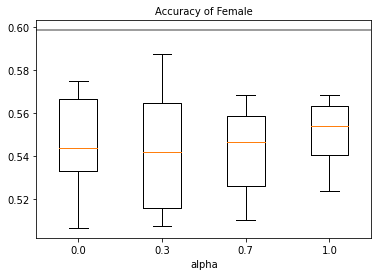

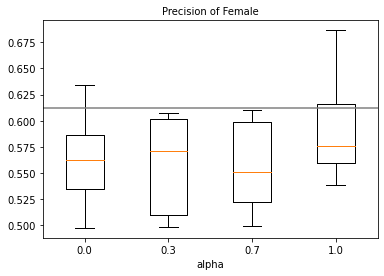

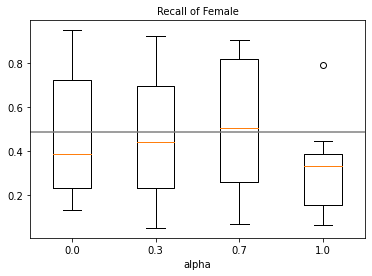

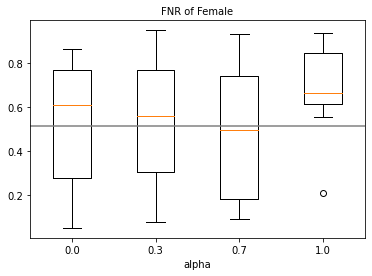

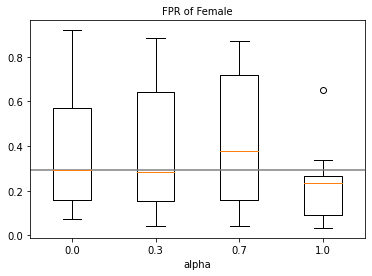

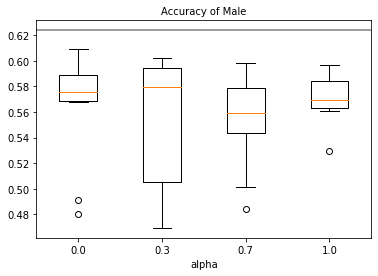

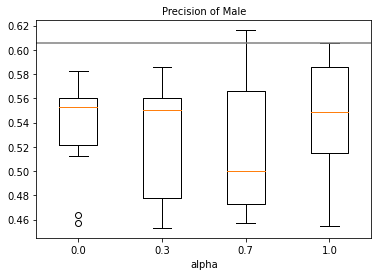

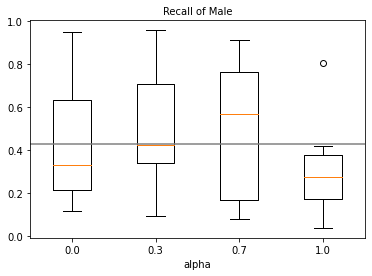

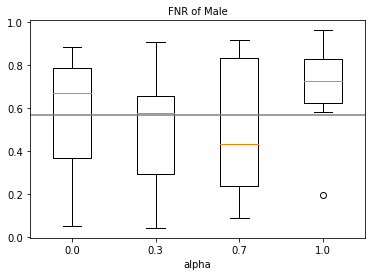

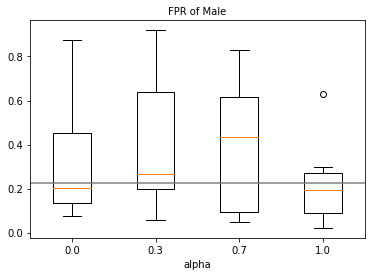

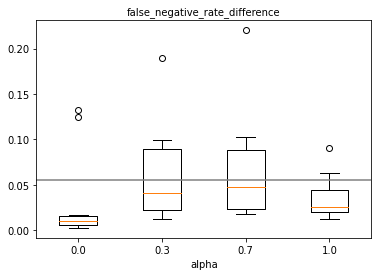

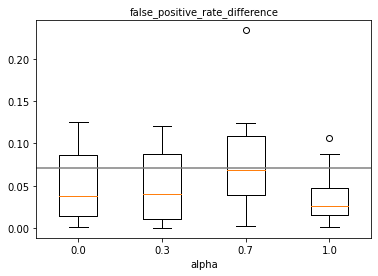

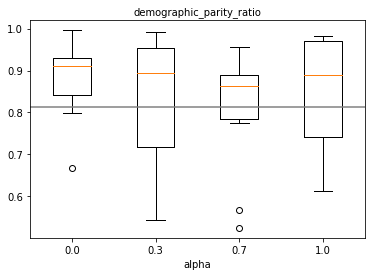

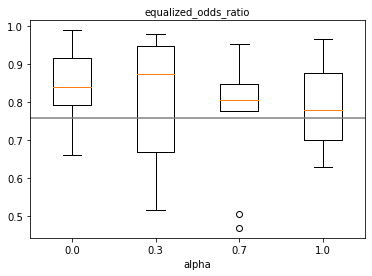

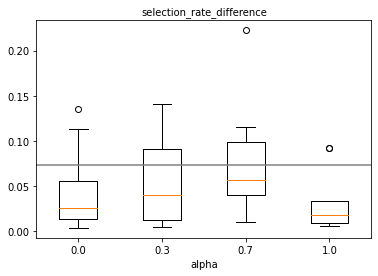

In [ ]:
for key in data_female:
    plt.boxplot(data_female[key], labels=alphas)
    plt.title('%s of Female'%key, fontsize=10)
    plt.axhline(metric_frame_p2_1.by_group[key]['female'], c = 'grey')
    plt.xlabel("alpha")
    plt.show()
for key in data_male:
    plt.boxplot(data_male[key], labels=alphas)
    plt.title('%s of Male'%key, fontsize=10)
    plt.axhline(metric_frame_p2_1.by_group[key]['male'], c = 'grey')
    plt.xlabel("alpha")
    plt.show()
for key in data:
    plt.boxplot(data[key], labels=alphas)
    plt.title('%s'%key, fontsize=10)
    plt.axhline(metric_frame_p2_2.overall[key], c = 'grey')
    plt.xlabel("alpha")
    plt.show()

Q4C:AdversarialFairnessClassifiers are less accurate and precise than the adjusted random forest model (b). They increase fairness metrics. When alpha rises, the demographic parity ratio and equalized odds ratio improve. The model becomes more fair as alpha grows, even at the sacrifice of accuracy. 
AdversarialFairnessClassifiers sacrifice fairness for accuracy, and alpha may be adjusted to reach the ideal balance.


# Problem 2, Part (d) 
### **Threshold Optimizer Post-processing intervention**



In [ ]:
#@markdown Fit the ThresholdOptimizer model here
data_female_p4 = {'Accuracy':[], 'Precision':[], 'Recall':[], 'FNR':[], 'FPR':[]}
data_male_p4 = {'Accuracy':[], 'Precision':[], 'Recall':[], 'FNR':[], 'FPR':[]}
data_p4 = {'false_negative_rate_difference':[],
                'false_positive_rate_difference':[],
                'demographic_parity_ratio':[],
                'equalized_odds_ratio':[],
                'selection_rate_difference':[]}

for i in range(10):
    print(i)
    # split dataset again
    X_train, X_test, y_train, y_test = train_test_split(x_numeric, y_raw, test_size=0.2, random_state = np.random.randint(10000))
    n_estimators = 1000
    max_depth = 10
    rf = RandomForestClassifier(n_estimators = n_estimators, max_depth = max_depth).fit(X_train, y_train)
    postprocessed_model = ThresholdOptimizer(
        estimator=rf,
        constraints='selection_rate_parity', # use selection_rate_parity to reflect fairness
        objective='balanced_accuracy_score',
        prefit=True,
        predict_method='predict_proba'
    )

    # Fit the model to the training data
    postprocessed_model.fit(X_train, y_train, sensitive_features=X_train['gender_Female'])

    # Predict on the test data
    y_pred_to = postprocessed_model.predict(X_test, sensitive_features=X_test['gender_Female'])  
    
    
    metric_frame_1 = MetricFrame(metrics=metric_dict_1,
                         y_true=y_test,
                         y_pred=y_pred_to,
                         sensitive_features=sensitive_feature)
    metric_frame_2 = MetricFrame(metrics=metric_dict_2,
                                 y_true=y_test,
                                 y_pred=y_pred_to,
                                 sensitive_features=sensitive_feature,
                                 sample_params=sample_params)
    for key in data_female_p4:
        data_female_p4[key].append(metric_frame_1.by_group[key]['female'])
    for key in data_male_p4:
        data_male_p4[key].append(metric_frame_1.by_group[key]['male'])
    for key in data_p4:
        data_p4[key].append(metric_frame_2.overall[key])
    


0
1
2
3
4
5
6
7
8
9


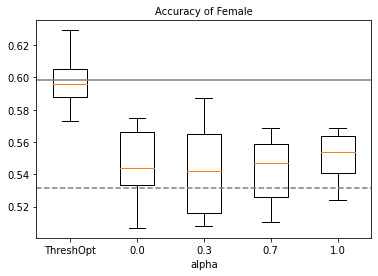

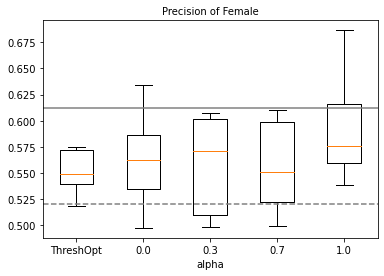

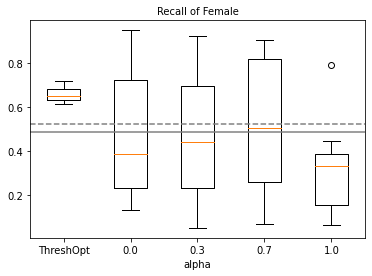

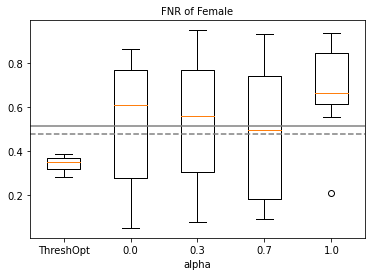

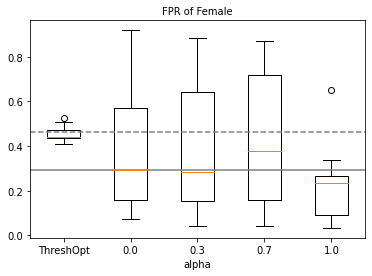

In [ ]:
for key in data_female_p4:
    plt.boxplot([data_female_p4[key]] + data_female[key], labels=['ThreshOpt'] + alphas)
    plt.title('%s of Female'%key, fontsize=10)
    plt.axhline(metric_frame_p2_1.by_group[key]['female'], c='grey')
    plt.axhline(metric_frame_p1_1.by_group[key]['female'], c='grey', ls='--')
    plt.xlabel("alpha")
    plt.show()


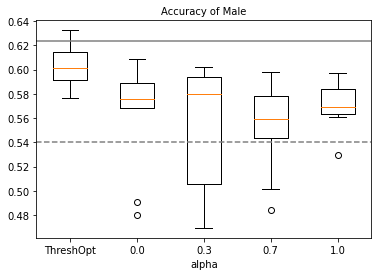

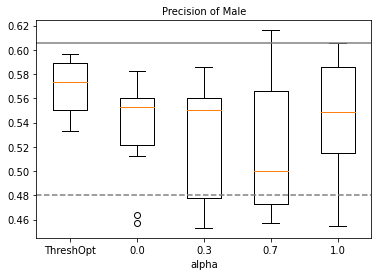

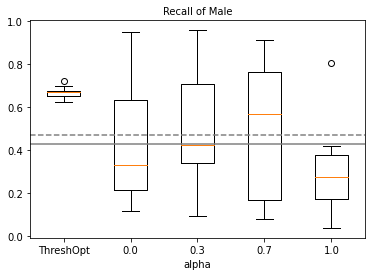

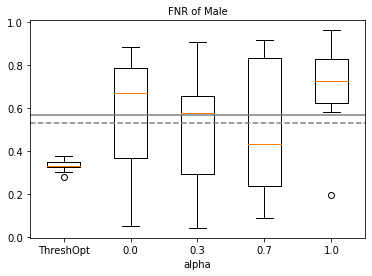

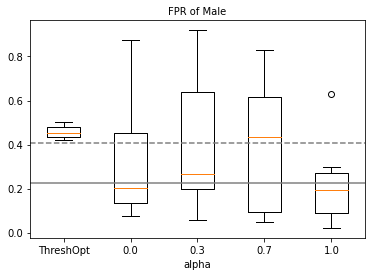

In [ ]:
for key in data_male_p4:
    plt.boxplot([data_male_p4[key]] + data_male[key], labels=['ThreshOpt'] + alphas)
    plt.title('%s of Male'%key, fontsize=10)
    plt.axhline(metric_frame_p2_1.by_group[key]['male'], c='grey')
    plt.axhline(metric_frame_p1_1.by_group[key]['male'], ls='--', c='grey')
    plt.xlabel("alpha")
    plt.show()


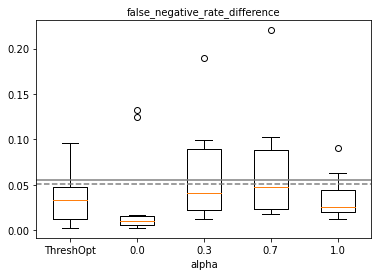

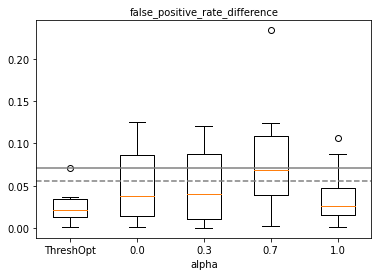

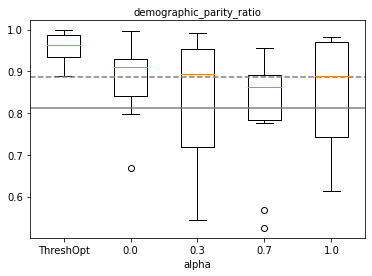

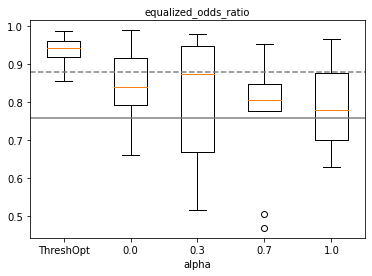

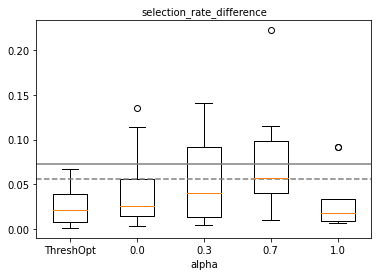

In [ ]:
for key in data_p4:
    plt.boxplot([data_p4[key]] + data[key], labels=['ThreshOpt'] + alphas)
    plt.title('%s'%key, fontsize=10)
    plt.axhline(metric_frame_p2_2.overall[key], c='grey')
    plt.axhline(metric_frame_p1_2.overall[key], c='grey', ls='--')
    plt.xlabel("alpha")
    plt.show()

Q4D: Based on the preceding questions, we may anticipate that the tuned random forest will be more accurate and precise than the untuned one. It may also be unfairer. The AdversarialFairnessClassifier with a low alpha value (0.0 or 0.3) may be more fair than the adjusted random forest but less accurate. 
The ThresholdOptimizer adjusts the categorization threshold to balance fairness and accuracy. Box-and-whisker charts show this algorithm's outcomes. 
ThresholdOptimizer increases fairness measures for both genders, according to box-and-whisker plots. For both genders, false negative, false positive, and selection rate differences decreased. 
ThresholdOptimizer matches the tweaked random forest model in 4(b) and the AdversarialFairnessClassifiers with alpha = 0.3 and 0.7 in accuracy and precision. . 
ThresholdOptimizer outperforms AdversarialFairnessClassifiers with alpha = 0.0 and alpha = 1.0 in accuracy, precision, and fairness measures.
